In [1]:
import os
import gc
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
warnings.filterwarnings(action = 'ignore')

In [2]:
train_transaction = pd.read_csv("../dataset/train_transaction.csv")
train_identity = pd.read_csv("../dataset/train_identity.csv")

test_transaction = pd.read_csv("../dataset/test_transaction.csv")
test_identity = pd.read_csv("../dataset/test_identity.csv")

In [3]:
%run DataPrepare.ipynb

In [4]:
train_df = pd.merge(left=train_transaction,right=train_identity,how='left',on = 'TransactionID')

In [5]:
del train_transaction, train_identity
gc.collect()

75

In [6]:
Reduce_Memory_Usage(train_df)

origin memory usage: 1959.8762512207031
reduced memory usage: 650.4761695861816
memory reduce (66.8%)


In [11]:
# 类别、离散特征
cate_col_list = ['ProductCD','P_emaildomain','R_emaildomain','DeviceType','DeviceInfo','addr1','addr2']

#循环加入特征
for i in range(1,7):
    cate_col_list.append('card' + str(i))
for i in range(1 ,10):
    cate_col_list.append('M' + str(i))
for i in range(12 ,39):
    cate_col_list.append('id_' + str(i // 10) + str(i % 10))
#连续型特征
continual_col_list = [x for x in train_df.columns if x not in cate_col_list]
continual_col_list.remove('isFraud')

# Handle Missing data

In [7]:
missing_col_list = list(train_df.columns[train_df.isnull().sum() > 0])

<AxesSubplot:>

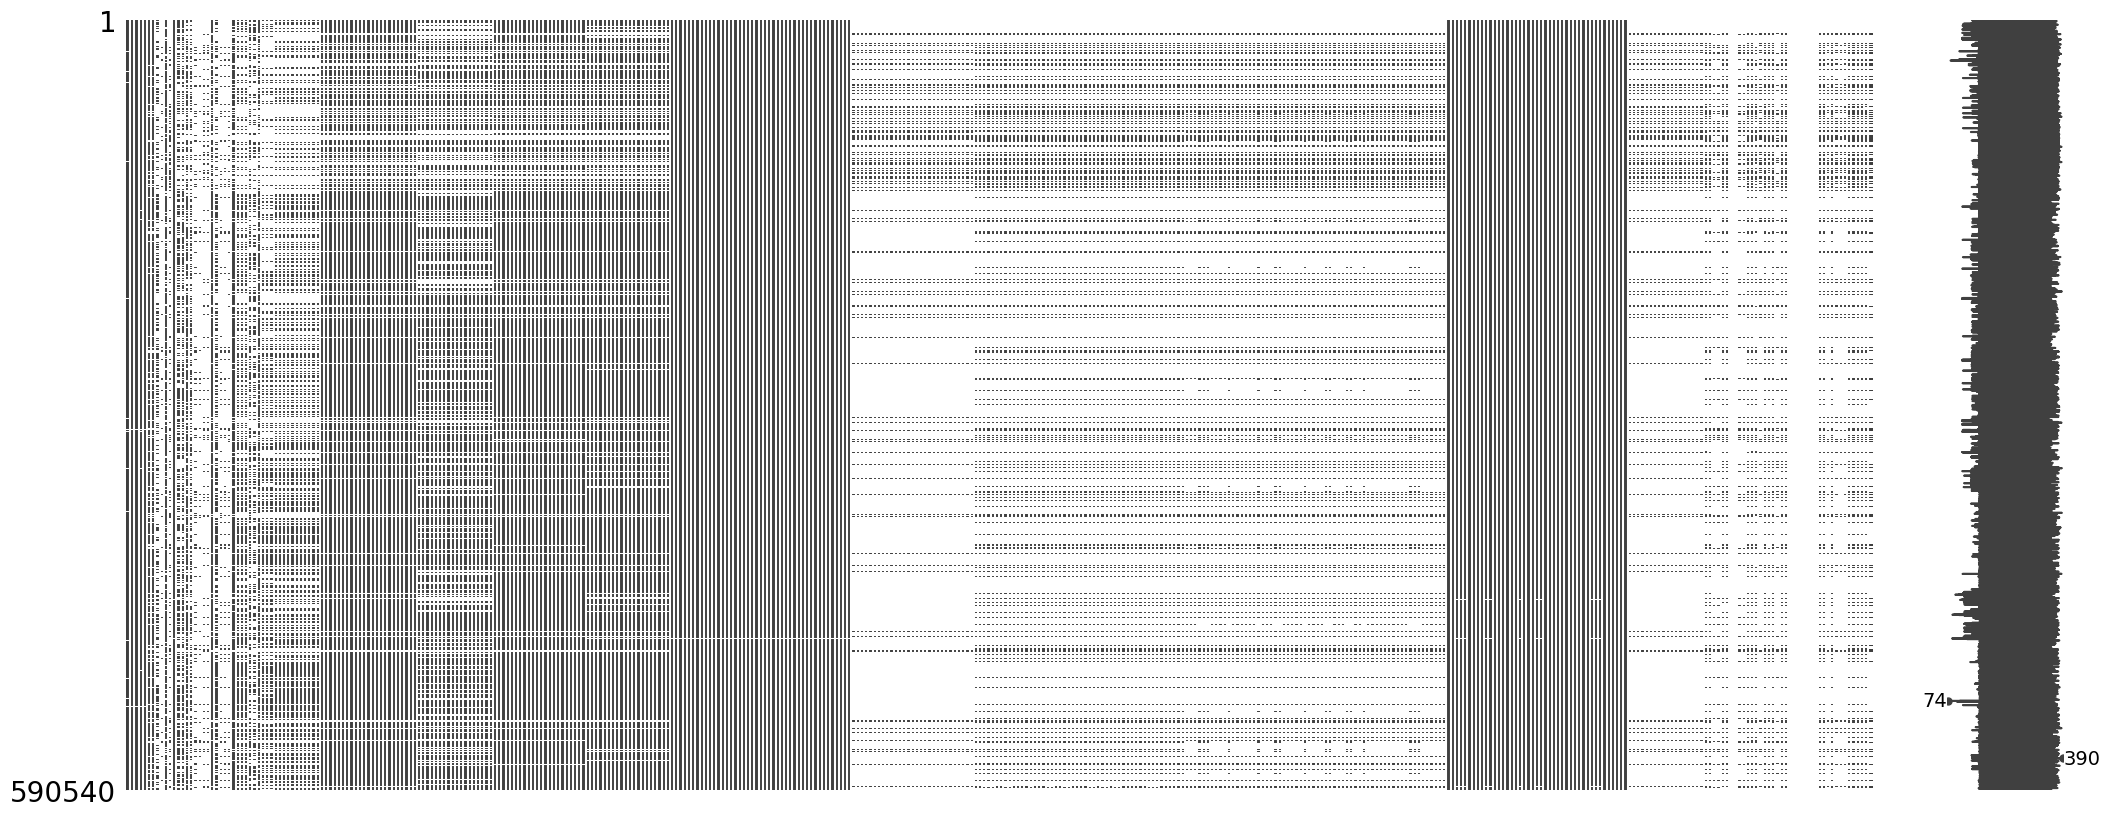

In [36]:
msno.matrix(df= train_df[missing_col_list])

In [21]:
%run Cleaning_utils.ipynb

### 采用多重插补算法对缺失值进行填充

In [14]:
train_y = train_df['isFraud']
train_df.drop(labels = ['isFraud'], axis = 1,inplace = True)

In [24]:
#get the str or object type feature names
str_col_list = [x for x in train_df.columns if str(train_df[x].dtype)[:3] not in ['int','flo']]

In [26]:
#encoding these feature to digital value firstly for missing values imputing
train_df['ProductCD'].value_counts()

W    439670
C     68519
R     37699
H     33024
S     11628
Name: ProductCD, dtype: int64

In [22]:
Missing_Impute_MICE(train_df)

ValueError: could not convert string to float: 'W'